####**Learning to denoise using noise2noise**









This lab has two parts. First we will train a simple denoiser, using an architecture similar to that used last week, and we will let it train on colab while you work on the main part of the lab which is on path tracing. At the end you will use your trained network to denoise the path traced image. 

We assume you have downloaded the data using the procedure communicated to you on your google drive.

First, check that all data has been downloaded as in the right place. You will need to login, and copy a code perform the next step.



In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive"

Mounted at /content/gdrive
MyDrive


In [ ]:
!ls '/content/gdrive/MyDrive/TP2/images/train'
!ls '/content/gdrive/MyDrive/TP2/images/test'

berry  bird  dog  flower  other
berry  bird  dog  flower  other


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


You should see this:


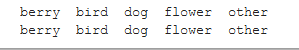

If you dont please rerun the download colab.

Next import all libraries required.

In [ ]:
import torch as th
from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
from IPython import display
import glob
from torchvision import transforms
import math
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
# web utilities to get images from the web
import requests

Let's setup our environement. We define the device on which to run the experiment here

In [ ]:
device = th.device("cpu")
#device = th.device("cuda:0") # Uncomment this to run on GPU

Use the same network architecture (with the ReLUs) as last week.

In [ ]:
class Net(th.nn.Module):
    def __init__(self, numLayers, inChannels, outChannels, numFeatures):
        super(Net, self).__init__()
        
        layers = OrderedDict()
        layers["inConv"] = th.nn.Conv2d(inChannels, numFeatures, 3, stride=1, padding=1)
        layers["inRelu"] = th.nn.ReLU()
        
        for l in range(numLayers):
            layers["conv{}".format(l)] = th.nn.Conv2d(numFeatures, numFeatures, 3, stride=1, padding=1)
            layers["relu{}".format(l)] = th.nn.ReLU()
        
        layers["outConv"] = th.nn.Conv2d(numFeatures, outChannels, 3, stride=1, padding=1)

        self.net = th.nn.Sequential(layers)
    
    def forward(self, x):
        return self.net(x)

Make sure you are on the right device (should get cuda:0)



In [ ]:
print(device)

cpu


Now initialize an instance, but use larger capacity (eg 48 features, 8 layers)

In [ ]:
numFeatures = 48
numLayers =  8
inChannels = 3 # Number of channels of the input
outChannels = 3 # Number of channels of the output

model = Net(numLayers,inChannels, outChannels, numFeatures)
#Put the model on the right device
model.to(device)

Net(
  (net): Sequential(
    (inConv): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (inRelu): ReLU()
    (conv0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU()
    (conv1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (conv3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU()
    (conv4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu4): ReLU()
    (conv5): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu5): ReLU()
    (conv6): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu6): ReLU()
    (conv7): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu7): ReLU()
    (outConv): Conv2d(48, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

We now create our optimizer

In [ ]:
optimizer = th.optim.Adam(model.parameters(), lr=0.0001)

We now create our loss, L1 or L2

In [ ]:
loss_func = th.nn.L1Loss()
#loss_func = th.nn.MSELoss()

For this Noise2Noise example we train the network to go from one corrupted version of an image, to another version corrupted using the same distribution. We will now use a data loader.
We use the Linnaeus Dataset 256x256 http://chaladze.com/l5/.  

These are in your google drive in the directory TP2/images (see download instructions if not).



Here we will use the Dataset class of pytorch. Note how there are two modes 'train' and 'val' (for validation). 

We create a dataset that contains triplets: a ground truth (GT) image, and two noisy versions with independent noise, called im_n0 and im_n1. We will access these during training. Use torch.randn to get a tensor of the same size and image_tensor and multiply it by the original to get the noisy versions (ie multiply self.std with randn)

In [ ]:
class LinnaeusDataset(Dataset,):
    def __init__(self,opt,mode,std=1.0):
        # Train and validation set; we only use train here
        if mode=='train':
            self.list_files=glob.glob('/content/gdrive/MyDrive/TP2/images/train/*/*.jpg')
        elif mode=='val':
            self.list_files=glob.glob('/content/gdrive/MyDrive/TP2/images/test/*/*.jpg')
        else:
            raise ValueError("Mode should be 'train or 'val'")
        self.opt=opt
        self.std=std

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self,idx):
        im = Image.open(self.list_files[idx])
        # Convert to tensor the PIL image, we unsqueeze to add a batch dimension
        image_tensor = torchvision.transforms.ToTensor()(im)
        # We center the image between -1 and 1
        image_tensor = 2*image_tensor - 1

        # We add two independent versions of gaussian noise
        im_n0 = image_tensor + th.randn(image_tensor.size())*self.std 
        im_n1 = image_tensor + th.randn(image_tensor.size())*self.std 

        return im_n0,im_n1,image_tensor

Now that we have our dataset class we can instanciate an dataset. Note how we use a batchsize of 10 to go faster, and we shuffle (randomize) the data.

In [ ]:
train_dataset=LinnaeusDataset(None,'train',std=0.3)
train_dataloader=DataLoader(train_dataset,batch_size=10,shuffle=True,num_workers=0)


runNet takes number of epochs (maxEpochs) and total number of steps (totalSteps).

In [ ]:
def runNet(maxEpochs, totalSteps ):
  #plot data
  x=[]
  y=[]
  fig = plt.figure(figsize=(25, 5))
  implt_n0 = fig.add_subplot(1,5,1)
  implt_n1 = fig.add_subplot(1,5,2)
  implt_out = fig.add_subplot(1,5,3)
  implt_gt = fig.add_subplot(1,5,4)
  lossplt = fig.add_subplot(1,5,5)

  step=0

  for ep in range(maxEpochs):
    print( "Epoch ", ep)
    for batch in train_dataloader:
        # print(device)
        im_n0,im_n1,gt=batch
        im_n0 = im_n0.to(device)
        im_n1 = im_n1.to(device)
        gt = gt.to(device)

        # We do the forward pass
        out = model(im_n0)
        # We compute the loss
        loss = loss_func(out,im_n1)

        # We reset the gradients to zero to avoid them accumulating
        optimizer.zero_grad()
        # We compute the backward pass
        loss.backward()

        # Based on the computed gradient we can execute a step of the optimizer.
        # That means modifying the weights of the model based on the learning rate and momentum
        optimizer.step()

        #Lets print the loss here
        if step%25 == 0:
            
            output_image = torchvision.transforms.ToPILImage()(th.clamp(0.5+out[0].cpu()/2.0, min=0.0, max=1.0)) # we do out[0] to remove the batch dimension
            gt_image = torchvision.transforms.ToPILImage()(th.clamp(0.5+gt[0].cpu()/2.0, min=0.0, max=1.0)) # we do out[0] to remove the batch dimension
            n0_image = torchvision.transforms.ToPILImage()(th.clamp(0.5+im_n0[0].cpu()/2.0, min=0.0, max=1.0)) # we do out[0] to remove the batch dimension
            n1_image = torchvision.transforms.ToPILImage()(th.clamp(0.5+im_n1[0].cpu()/2.0, min=0.0, max=1.0)) # we do out[0] to remove the batch dimension
            
         
            x.append(step)
            y.append(loss.item())
            
            
            implt_n0.imshow(n0_image)
            implt_n1.imshow(n1_image)
            implt_out.imshow(output_image)
            implt_gt.imshow(gt_image)
            implt_gt.title.set_text("step:"+str(step)+"/" + str(len(train_dataloader.dataset)) +" loss:"+str(loss.item()))
            lossplt.plot(x,y)
            lossplt.title.set_text("Loss")
            
            display.display(fig)
            display.clear_output(wait=True)
            
            
            plt.show()
        step+=1
        if( step > totalSteps ):
            return


        
        

Test run (takes 2-3 minutes); you should get something that looks like the image below (but the actual image will be different due to randonmess). You can start looking at the shadertoy lab in the meantime.

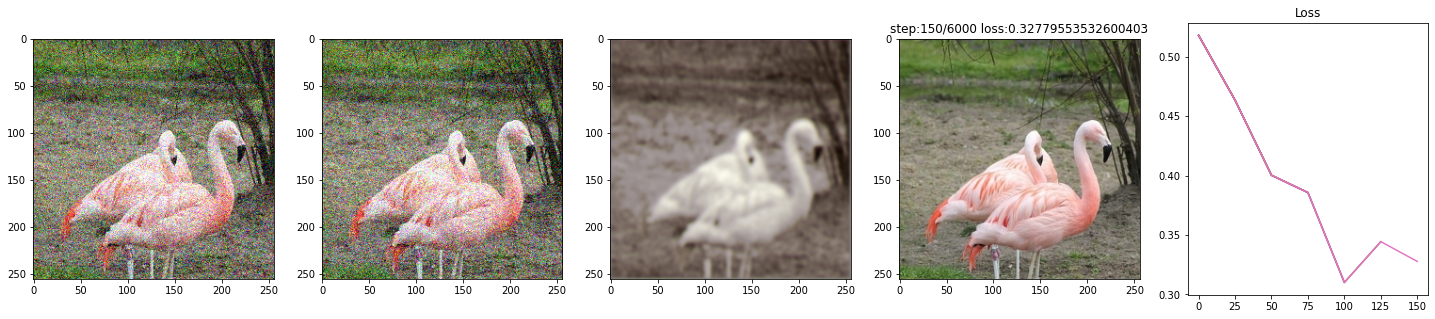

In [ ]:
runNet(1, 150)

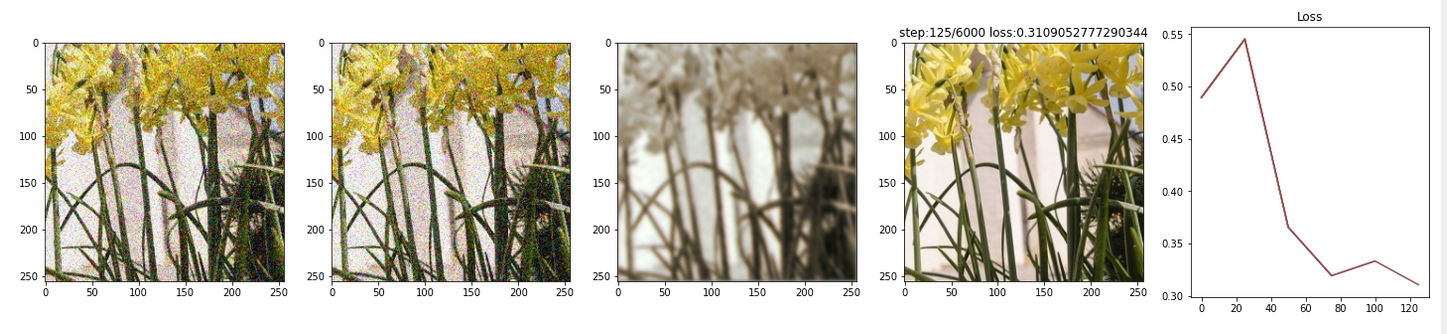

If things look ok, you can now run the full optimization. This will take more than 30 min, but you will be working on the path tracer during this time; just let the process run. 

First, reset the optimizer.

In [ ]:
optimizer = th.optim.Adam(model.parameters(), lr=0.0001)

Now run the full optimization.

In [ ]:
runNet(4, 240000)

At the end of the session, when you have finished the path tracing part, you will be able to run the denoiser on your images. Upload some of your images to TP2/ and run the network.

In [ ]:
import matplotlib.pyplot as plt
import cv2 as cv
from PIL import Image
image1 = cv.imread('/content/gdrive/MyDrive/TP2/canvas.png', cv.COLOR_RGB2BGR)
image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)
plt.imshow(image1)


In [ ]:
# Crop image to contain the square part only
gray = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
_,thresh = cv.threshold(gray,3,255,cv.THRESH_BINARY)
contours,hierarchy = cv.findContours(thresh,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
x,y,w,h = cv.boundingRect(cnt)
crop = image1[y:y+h,x:x+w+1]
print(" x ", x, " y ", y , " w ", w , " h ", h)
plt.imshow(crop)

In [ ]:
image1_tensor = torchvision.transforms.ToTensor()(crop).unsqueeze(0)
image1_tensor = image1_tensor.to(device)
x=[]
y=[]
figresult = plt.figure(figsize=(25, 5))
original = figresult.add_subplot(1,5,1)
denoised = figresult.add_subplot(1,5,2)


out = model(image1_tensor)
output_image = torchvision.transforms.ToPILImage()(th.clamp(out[0].cpu(), min=0.0, max=1.0)) # we do out[0] to remove the batch dimension
original.imshow(crop)
denoised.imshow(output_image)